In [12]:
import torch

In [1]:
import xarray as xr
import numpy as np

# Initialize an empty xarray Dataset
ds = xr.Dataset(
    {
        'O': (['L', 'p_ctrl', 'p_proj', 'trial'], np.empty((0, 0, 0, 0))),
        'EE': (['L', 'p_ctrl', 'p_proj', 'trial'], np.empty((0, 0, 0, 0))),
        'TMI': (['L', 'p_ctrl', 'p_proj', 'trial'], np.empty((0, 0, 0, 0)))
    },
    coords={
        'L': [],
        'p_ctrl': [],
        'p_proj': [],
        'trial': []
    }
)


In [2]:
ds

<xarray.Dataset>
Dimensions:  (L: 0, p_ctrl: 0, p_proj: 0, trial: 0)
Coordinates:
  * L        (L) float64 
  * p_ctrl   (p_ctrl) float64 
  * p_proj   (p_proj) float64 
  * trial    (trial) float64 
Data variables:
    O        (L, p_ctrl, p_proj, trial) float64 
    EE       (L, p_ctrl, p_proj, trial) float64 
    TMI      (L, p_ctrl, p_proj, trial) float64

In [28]:
def add_new_data(ds, d):
    # Extract parameter values
    L = np.arange(*d['args'].L)
    p_ctrl = np.linspace(d['args'].p_ctrl[0],d['args'].p_ctrl[1],int(d['args'].p_ctrl[2]))
    p_proj = np.linspace(d['args'].p_proj[0],d['args'].p_proj[1],int(d['args'].p_proj[2]))
    
    # Convert torch tensor to numpy for easier handling with xarray
    datasets = {
        
    }
    for key in ['O','EE','TMI']:
        if torch.is_tensor(d[key]):
            data_np=d[key].cpu().numpy()
        else:
            data_np=d[key]
        datasets[key]= data_np

    # Handle each parameter combination
    for l in L:
        for pc in p_ctrl:
            for pp in p_proj:
                # Check if the parameter combination exists
                condition = (ds['L'] == l) & (ds['p_ctrl'] == pc) & (ds['p_proj'] == pp)
                
                if condition.sum() > 0:
                    # If the combination exists, append new trials
                    for key, data in datasets.items():
                        current_data = ds.loc[dict(L=l, p_ctrl=pc, p_proj=pp)][key]
                        new_data = np.concatenate([current_data, data], axis=-1)
                        ds.loc[dict(L=l, p_ctrl=pc, p_proj=pp)][key] = new_data

                else:
                    # If the combination does not exist, add a new record
                    new_data_dict = {key: (('L', 'p_ctrl', 'p_proj', 'trial'), data) 
                                     for key, data in datasets.items()}
                    
                    new_dataset = xr.Dataset(
                        new_data_dict,
                        coords={
                            'L': L,
                            'p_ctrl': p_ctrl,
                            'p_proj': p_proj,
                            'trial': np.arange(datasets['O'].shape[-1])
                        }
                    )
                    
                    ds = xr.concat([ds, new_dataset], dim=['L', 'p_ctrl', 'p_proj'])

    return ds

In [10]:
import pickle
import os

In [7]:
with open(os.path.join('Data','CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(10,14,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'),'rb') as f:
    data=pickle.load(f)

In [30]:
ds=add_new_data(ds,data)

ValueError: conflicting sizes for dimension 'concat_dim': length 3 on 'concat_dim' and length 2 on {'L': 'L', 'p_ctrl': 'p_ctrl', 'p_proj': 'p_proj', 'trial': 'trial', 'concat_dim': 'O'}

In [ ]:
# Extract data where p_proj=0
subset = ds.sel(param_p_proj=0)

# Compute the average of 'O' across the trial dimension
average_O = subset['O'].mean(dim='trial')


In [89]:
with open(os.path.join('Data','CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(10,14,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'),'rb') as f:
    data=pickle.load(f)

In [151]:
np.round(np.linspace(0,1,11),3)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [291]:
def add_to_dict(data_dict,data,filename):
    if filename in data_dict['fn']:
        print(f'File duplicated: {filename}' )
    else:
        data_dict['fn'].append(filename)
        L_list=np.arange(*data['args'].L)
        p_ctrl_list=np.round(np.linspace(data['args'].p_ctrl[0],data['args'].p_ctrl[1],int(data['args'].p_ctrl[2])),3)
        p_proj_list=np.round(np.linspace(data['args'].p_proj[0],data['args'].p_proj[1],int(data['args'].p_proj[2])),3)
        for key in ['O','EE','TMI']:
            for L_idx,L in enumerate(L_list):
                for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
                    for p_proj_idx,p_proj in enumerate(p_proj_list):
                            observations=data[key][L_idx,p_ctrl_idx,p_proj_idx]
                            if torch.is_tensor(observations):
                                observations=observations.cpu().tolist()
                            params=(key,L,p_ctrl,p_proj)
                            if params in data_dict:
                                data_dict[params]=data_dict[params]+observations
                            else:
                                data_dict[params]=observations
                    



In [330]:
data_dict={'fn':[]}

## pctrl [0,1,11], p_proj[0,0,1] L(8,10,2)

In [331]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(8,10,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(10,14,2)

In [301]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(10,14,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(14,16,2)

In [302]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(14,16,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(16,18,2)

In [303]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(16,18,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(18,20,2)

In [304]:
for s in range(2):
    fn=f'CT_En1000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(18,20,2)_xj(1-3,2-3)_seed{s}_es1000_64.pickle'
    with open(os.path.join('Data',fn),'rb') as f:
        data=pickle.load(f)
    add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(20,22,2)

In [305]:
for s in range(2):
    for p_ctrl in np.linspace(0,1,11):
        fn=f'CT_En1000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj(0.00,0.00,1)_L(20,22,2)_xj(1-3,2-3)_seed{s}_es1000_64.pickle'
        with open(os.path.join('Data',fn),'rb') as f:
            data=pickle.load(f)
        add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(22,24,2)

In [306]:
for s in range(10):
    for p_ctrl in np.linspace(0,1,11):
        fn=f'CT_En200_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj(0.00,0.00,1)_L(22,24,2)_xj(1-3,2-3)_seed{s}_es200_64.pickle'
        with open(os.path.join('Data',fn),'rb') as f:
            data=pickle.load(f)
        add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(24,26,2)

In [308]:
for s in range(25):
    for p_ctrl in np.linspace(0,1,11):
        fn=f'CT_En80_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed{s}_es80_64.pickle'
        try:
            with open(os.path.join('Data',fn),'rb') as f:
                data=pickle.load(f)
        except:
            print(f'File missing: {fn}')
        add_to_dict(data_dict, data,fn)

File missing: CT_En80_pctrl(0.70,0.70,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed0_es80_64.pickle
File missing: CT_En80_pctrl(0.90,0.90,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed0_es80_64.pickle
File missing: CT_En80_pctrl(1.00,1.00,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed0_es80_64.pickle
File missing: CT_En80_pctrl(0.90,0.90,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed1_es80_64.pickle
File missing: CT_En80_pctrl(1.00,1.00,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed1_es80_64.pickle
File missing: CT_En80_pctrl(0.90,0.90,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed2_es80_64.pickle
File missing: CT_En80_pctrl(0.90,0.90,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed3_es80_64.pickle
File missing: CT_En80_pctrl(1.00,1.00,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed3_es80_64.pickle
File missing: CT_En80_pctrl(0.90,0.90,1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed4_es80_64.pickle
File missing: CT_En80_pctrl(1.00,1.00,1)_pproj(0.00,0.00,1)_L(24

## pctrl [0,1,11], p_proj[0,0,1] L(24,26,2)

In [332]:
for s in range(1):
    for p_ctrl in np.linspace(0,1,11)[1:]:
        for p_proj in np.linspace(0,1,11):
            fn=f'CT_En2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(10,12,2)_xj(1-3,2-3)_seed{s}_es2000_64.pickle'
            try:
                with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
            except:
                print(f'File missing: {fn}')
            add_to_dict(data_dict, data,fn)

## Convert to pandas

In [334]:
index = pd.MultiIndex.from_tuples([key for key in data_dict.keys() if key!='fn'], names=['Metrics','L', 'p_ctrl', 'p_proj'])

In [335]:
df = pd.DataFrame({'observations': [val for key,val in data_dict.items() if key!='fn']}, index=index)


In [336]:
df.query("Metrics=='O' and L==10")['observations'].apply(len)

Metrics  L   p_ctrl  p_proj
O        10  0.1     0.0       2000
                     0.1       2000
                     0.2       2000
                     0.3       2000
                     0.4       2000
                               ... 
             1.0     0.6       2000
                     0.7       2000
                     0.8       2000
                     0.9       2000
                     1.0       2000
Name: observations, Length: 110, dtype: int64

In [337]:
df.index.get_level_values('L').unique()

Int64Index([8, 10], dtype='int64', name='L')

In [246]:
import matplotlib.pyplot as plt

Text(0.5, 0, '$p_{ctrl}$')

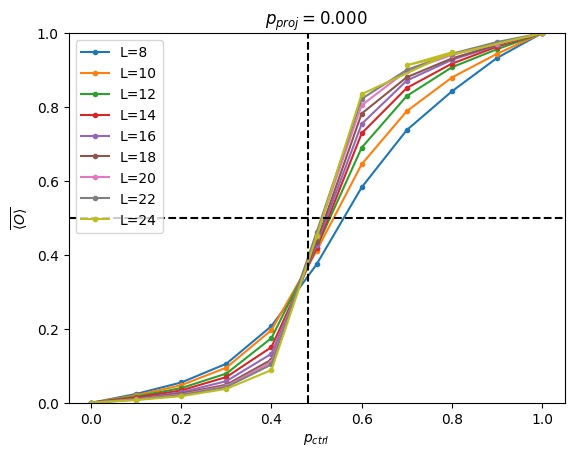

In [318]:
fig,ax=plt.subplots()
for L in df.index.get_level_values('L').unique():
    dd=df.xs(key='O',level='Metrics').xs(key=L,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None)
    ax.plot(dd.index.get_level_values('p_ctrl'),dd,'.-',label=f'L={L}')
    # ax.plot(p_ctrl_list,data['O'][i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

In [ ]:
subset = df.xs(key=0, level='first_index')  # Slicing by first index


In [79]:
# Access data by slicing
subset = df.xs(key=0, level='first_index')  # Slicing by first index
print(subset)


                          observations
second_index third_index              
0            0               [1, 2, 3]
             1                  [4, 5]
1            0            [6, 7, 8, 9]


In [84]:
subset=df.loc[(0,slice(None),0),:]

In [85]:
subset

observations
first_index second_index third_index              
0           0            0               [1, 2, 3]
            1            0            [6, 7, 8, 9]

In [86]:

# Compute mean over the observations in the slice
mean_values = subset['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None)
print(mean_values)

first_index  second_index  third_index
0            0             0              2.0
             1             0              7.5
Name: observations, dtype: float64


In [345]:
dd_O=df.xs(key='O',level='Metrics').xs(key=10,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None)
# ax.plot(dd.index.get_level_values('p_ctrl'),dd,'.-',label=f'L={L}')

In [350]:
dd_TMI=df.xs(key='TMI',level='Metrics').xs(key=10,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None)
# ax.plot(dd.index.get_level_values('p_ctrl'),dd,'.-',label=f'L={L}')

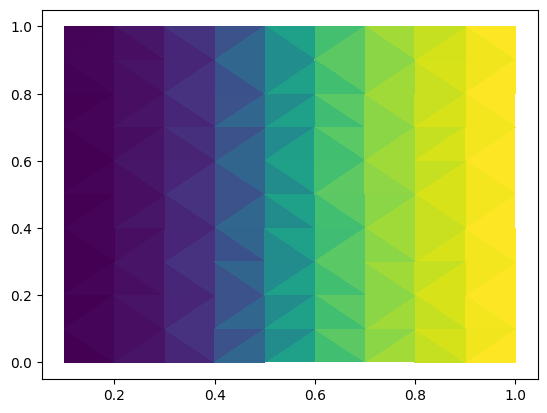

In [347]:
plt.tripcolor(dd_O.index.get_level_values('p_ctrl'),dd_O.index.get_level_values('p_proj'),dd_O)

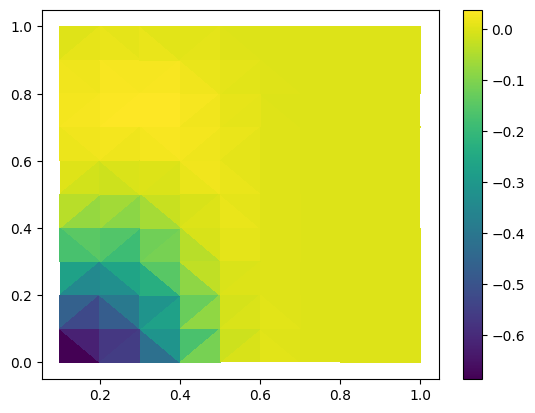

In [352]:
plt.tripcolor(dd_TMI.index.get_level_values('p_ctrl'),dd_TMI.index.get_level_values('p_proj'),np.tanh(dd_TMI))
plt.colorbar()

In [339]:
df.xs(key='O',level='Metrics').xs(key=10,level='L')

observations
p_ctrl p_proj                                                   
0.1    0.0     [0.11355884373188019, -0.006186807062476873, 0...
       0.1     [-0.05787568911910057, 0.12830987572669983, 0....
       0.2     [-0.07296345382928848, 0.1639474779367447, 0.0...
       0.3     [0.11032654345035553, 0.13042622804641724, -0....
       0.4     [0.14246736466884613, 0.0904230922460556, 0.30...
...                                                          ...
1.0    0.6     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
       0.7     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
       0.8     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
       0.9     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
       1.0     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[110 rows x 1 columns]